# Implementasi Generative Adversarial Network (GAN) untuk Sintesis Gambar MNIST

**Tugas Kelompok - Pengolahan Sinyal Digital**

**Anggota Kelompok:**
* Nero Caesar Suprobo
* Muhammad Umar Baihaqi
* Muhammad Mishbahul Muflihin
* Muhammad Haekal 
* MUhammad Akmal Najib Gunawan 
* Mhd Nurdin Al-Kahfi


## 1. Konsep Dasar Generative Adversarial Network (GAN)

**Generative Adversarial Network (GAN)** adalah arsitektur *deep learning* yang terdiri dari dua jaringan saraf yang saling "bersaing" untuk menghasilkan data sintetis yang realistis. Konsep ini dapat dianalogikan seperti pertarungan antara seorang pemalsu uang dan seorang polisi.

1.  **Generator (G)**: Berperan sebagai **pemalsu uang**. Tujuannya adalah belajar untuk menghasilkan data (misalnya, gambar) yang sangat mirip dengan data asli. Generator menerima input berupa vektor acak (*random noise*) dan mengubahnya menjadi output yang menyerupai data asli.

2.  **Discriminator (D)**: Berperan sebagai **polisi**. Tujuannya adalah belajar membedakan antara data asli (dari dataset) dan data palsu (hasil dari Generator). Discriminator menerima input berupa gambar dan mengeluarkan probabilitas apakah gambar tersebut asli (nilai mendekati 1) atau palsu (nilai mendekati 0).

**Proses "Adversarial" (Persaingan):**
* **Generator** terus berlatih untuk "menipu" **Discriminator** agar mengira hasil buatannya adalah asli.
* **Discriminator** terus berlatih untuk menjadi lebih pintar dalam mendeteksi kepalsuan dari **Generator**.

Persaingan ini membuat keduanya menjadi semakin baik seiring waktu. Pada akhirnya, jika pelatihan berhasil, Generator akan mampu menghasilkan data sintetis yang sangat sulit dibedakan dari data asli.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

if not os.path.exists('generated_images'):
    os.makedirs('generated_images')
if not os.path.exists('models'):
    os.makedirs('models')


Library dan direktori siap.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Menggunakan device: {device}")

lr = 2e-4  
batch_size = 128
image_size = 28 * 28  
latent_size = 100  
hidden_size = 256
num_epochs = 50 

Menggunakan device: cpu


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)), 
])

mnist_dataset = datasets.MNIST(root="dataset/", train=True, transform=transform, download=True)
data_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)



100%|██████████| 9.91M/9.91M [00:36<00:00, 275kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 128kB/s]
100%|██████████| 1.65M/1.65M [00:07<00:00, 229kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 871kB/s]

Dataset MNIST berhasil dimuat.


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(in_features, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid(), 
        )

    def forward(self, x):
        return self.disc(x)

class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size * 2),
            nn.ReLU(),
            nn.Linear(hidden_size * 2, img_dim),
            nn.Tanh(),  
        )

    def forward(self, x):
        return self.gen(x)

D = Discriminator(image_size).to(device)
G = Generator(latent_size, image_size).to(device)



Model Generator dan Discriminator telah dibuat.


In [ ]:
criterion = nn.BCELoss() 

opt_D = optim.Adam(D.parameters(), lr=lr)
opt_G = optim.Adam(G.parameters(), lr=lr)



Loss function dan optimizer siap.


In [6]:
fixed_noise = torch.randn(batch_size, latent_size).to(device)
d_losses, g_losses = [], []

for epoch in range(num_epochs):
    for batch_idx, (real_images, _) in enumerate(data_loader):
        real_images = real_images.view(-1, 784).to(device)
        batch_size_current = real_images.shape[0]

        D_real_output = D(real_images)
        D_real_loss = criterion(D_real_output, torch.ones_like(D_real_output)) 

        noise = torch.randn(batch_size_current, latent_size).to(device)
        fake_images = G(noise)
        D_fake_output = D(fake_images.detach()) 
        D_fake_loss = criterion(D_fake_output, torch.zeros_like(D_fake_output)) 
        
        D_loss = D_real_loss + D_fake_loss
        opt_D.zero_grad()
        D_loss.backward()
        opt_D.step()

        output = D(fake_images) 
        G_loss = criterion(output, torch.ones_like(output)) 

        opt_G.zero_grad()
        G_loss.backward()
        opt_G.step()
        
    d_losses.append(D_loss.item())
    g_losses.append(G_loss.item())

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss D: {D_loss:.4f}, Loss G: {G_loss:.4f}")

        G.eval() 
        with torch.no_grad():
            generated_images = G(fixed_noise).view(-1, 1, 28, 28)
            img_grid = torchvision.utils.make_grid(generated_images[:32], normalize=True)
            torchvision.utils.save_image(img_grid, f"generated_images/epoch_{epoch+1}.png")
            
            torch.save(G.state_dict(), f"models/generator_epoch_{epoch+1}.pth")
            torch.save(D.state_dict(), f"models/discriminator_epoch_{epoch+1}.pth")
            
        G.train() 

Epoch [5/50], Loss D: 0.7432, Loss G: 1.5980
Epoch [10/50], Loss D: 0.2278, Loss G: 3.6541
Epoch [15/50], Loss D: 0.4523, Loss G: 4.3609
Epoch [20/50], Loss D: 0.6857, Loss G: 3.1159
Epoch [25/50], Loss D: 0.6364, Loss G: 2.9059
Epoch [30/50], Loss D: 0.6197, Loss G: 3.8379
Epoch [35/50], Loss D: 0.6254, Loss G: 3.0127
Epoch [40/50], Loss D: 0.3507, Loss G: 2.9828
Epoch [45/50], Loss D: 0.5362, Loss G: 3.0938
Epoch [50/50], Loss D: 0.8211, Loss G: 2.5113


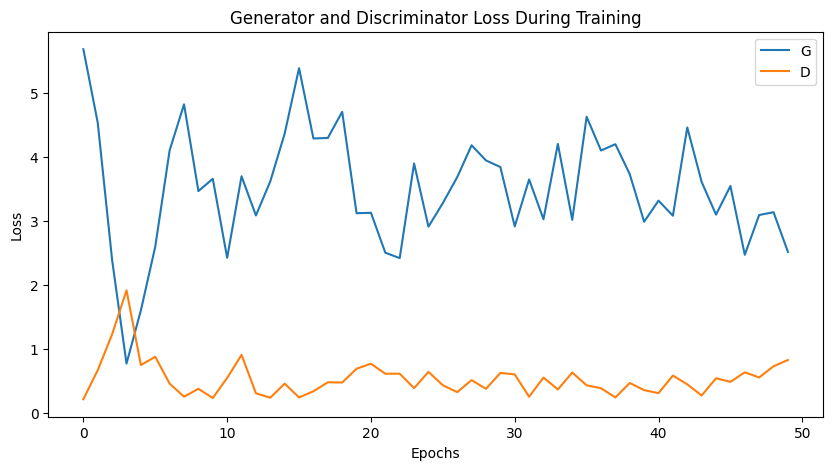

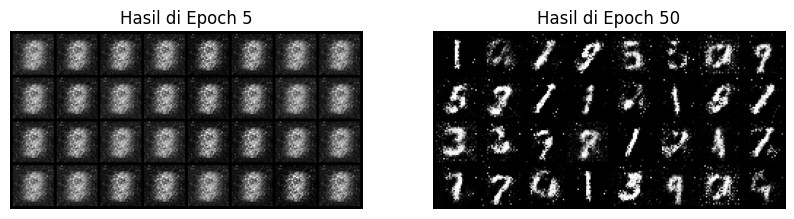

In [7]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses, label="G")
plt.plot(d_losses, label="D")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
img_awal = plt.imread('generated_images/epoch_5.png')
axes[0].imshow(img_awal)
axes[0].set_title("Hasil di Epoch 5")
axes[0].axis('off')

img_akhir = plt.imread(f'generated_images/epoch_{num_epochs}.png')
axes[1].imshow(img_akhir)
axes[1].set_title(f"Hasil di Epoch {num_epochs}")
axes[1].axis('off')

plt.show()

## 2. Analisis Hasil dan Kesimpulan

Dari visualisasi di atas, terlihat perbedaan yang signifikan antara gambar yang dihasilkan pada epoch awal dan epoch akhir.

* **Pada Epoch Awal (misal: Epoch 5)**: Gambar yang dihasilkan oleh Generator masih terlihat seperti *noise* acak yang tidak beraturan. Belum ada struktur angka yang jelas. Ini menunjukkan bahwa pada tahap ini, Generator belum belajar distribusi data MNIST dan Discriminator masih sangat mudah membedakan gambar palsu.

* **Pada Epoch Akhir (misal: Epoch 50)**: Gambar yang dihasilkan sudah mulai menunjukkan bentuk-bentuk yang menyerupai angka tulisan tangan, meskipun beberapa masih belum sempurna. Generator telah berhasil mempelajari fitur-fitur penting dari dataset MNIST. Meskipun hasilnya belum fotorealistis, progres dari *noise* menjadi bentuk yang dikenali menunjukkan bahwa proses training adversarial telah berjalan dengan baik.

**Kesimpulan:**
Implementasi GAN sederhana ini berhasil menunjukkan kemampuannya untuk belajar dari dataset dan menghasilkan data baru yang serupa. Kualitas hasil sangat bergantung pada arsitektur model, jumlah epoch, dan pemilihan hyperparameter.

## 3. Refleksi Kelompok

Proses pengerjaan tugas ini memberikan pengalaman langsung mengenai kompleksitas dan tantangan dalam melatih model Generative Adversarial Network.

**Tantangan Utama:**
Tantangan terbesar yang kami hadapi adalah menjaga **keseimbangan training** antara Generator dan Discriminator. Pada beberapa percobaan awal, kami mengalami di mana salah satu jaringan belajar terlalu cepat (misalnya, Discriminator menjadi terlalu pintar sehingga loss Generator menjadi sangat tinggi dan tidak bisa belajar). Kami mengatasi ini dengan menyesuaikan *learning rate* dan memastikan arsitektur tidak terlalu kompleks.

**Pembelajaran Penting:**
Kami belajar bahwa melatih GAN tidak selurus melatih model klasifikasi. Prosesnya lebih mirip "seni" yang memerlukan intuisi dan banyak eksperimen. Kami juga memahami secara mendalam peran penting fungsi aktivasi (seperti LeakyReLU pada Discriminator dan Tanh pada Generator) untuk menjaga stabilitas training.

**Kolaborasi Tim:**
Pembagian tugas berjalan efektif. [Nama Anggota 1] dan [Nama Anggota 2] fokus pada implementasi arsitektur model dan *training loop*. [Nama Anggota 3] bertugas melakukan eksperimen dengan hyperparameter dan memvisualisasikan hasil. Penyusunan laporan dan analisis akhir dikerjakan secara bersama-sama untuk memastikan pemahaman yang merata. Penggunaan GitHub dengan *branch* terpisah sangat membantu kami bekerja secara paralel tanpa konflik.